In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from skorch.regressor import NeuralNetRegressor
from tabularasa.MixedMonotonicNet import MixedMonotonicNet
from tabularasa.OrthonormalCertificates import OrthonormalCertificates
from tabularasa.OrthonormalCertificatesRegressor import OrthonormalCertificatesNet, OrthonormalCertificatesRegressor

In [2]:
df = pd.read_pickle('./examples/data/simple_train.pkl')

In [3]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(1 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1, None].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

In [4]:
model = NeuralNetRegressor(MixedMonotonicNet,
                           max_epochs=25,
                           lr=0.001,
                           optimizer=torch.optim.Adam,
                           iterator_train__shuffle=True,
                           module__non_monotonic_net=EmbeddingNet(),
                           module__dim_non_monotonic=16,
                           module__dim_monotonic=2,
                           module__layers=[128, 128, 32],
                           module__integration_steps=300)

In [5]:
model.fit({'X_monotonic': df[['x1', 'x2']].values,
           'X_non_monotonic': df[['x3', 'x4']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6781        0.3967  8.4549
      2        0.3514        0.2993  7.2144
      3        0.3045        0.2938  7.3422
      4        0.3010        0.2928  7.7490
      5        0.2961        0.2814  8.1085
      6        0.2892        0.2783  7.7929
      7        0.2807        0.2697  7.9993
      8        0.2697        0.2579  8.0213
      9        0.2561        0.2423  8.4501
     10        0.2376        0.2235  7.9034
     11        0.2154        0.2007  7.4041
     12        0.1902        0.1773  7.8323
     13        0.1682        0.1513  7.6674
     14        0.1455        0.1420  7.6534
     15        0.1258        0.1480  7.5849
     16        0.1183        0.1299  7.6836
     17        0.1026        0.1232  7.6226
     18        0.0969        0.1199  7.3500
     19        0.0910        0.1183  7.4099
     20        0.0867        0.1169  7.3427
     21        0.0833        0.1

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MixedMonotonicNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=17, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (inner_net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
          )
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
            (6): Linear(in_features=32

In [6]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [7]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                       'X_non_monotonic': dfc[['x3', 'x4']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

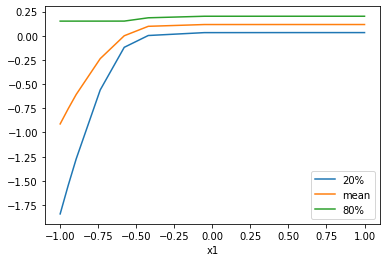

In [8]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

### Estimate epistemic uncertainty via orthonormal certificates

Start by prepping data from the inner hidden layer.

In [9]:
model.module_.set_last_layer(inner=True)

In [10]:
X_inner = model.predict({'X_monotonic': df[['x1', 'x2']].values,
                         'X_non_monotonic': df[['x3', 'x4']].values})

In [11]:
ocr = OrthonormalCertificatesRegressor(OrthonormalCertificatesNet,
                                       max_epochs=500,
                                       lr=0.01,
                                       optimizer=torch.optim.Adam,
                                       iterator_train__shuffle=True,
                                       module__dim_input=3 + 32)

In [12]:
ocr.fit(np.concatenate([df[['x1', 'x2', 'x4']].values, X_inner], axis=1))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.4872        0.4665  0.3190
      2        0.3567        0.2183  0.0565
      3        0.1432        0.0998  0.0592
      4        0.0726        0.0476  0.0489
      5        0.0387        0.0318  0.0477
      6        0.0230        0.0200  0.0559
      7        0.0179        0.0161  0.0551
      8        0.0149        0.0141  0.0490
      9        0.0136        0.0133  0.0568
     10        0.0130        0.0131  0.0486
     11        0.0126        0.0126  0.0575
     12        0.0123        0.0123  0.0586
     13        0.0121        0.0122  0.0610
     14        0.0119        0.0120  0.0565
     15        0.0117        0.0119  0.0455
     16        0.0116        0.0117  0.0507
     17        0.0115        0.0116  0.0583
     18        0.0114        0.0115  0.0495
     19        0.0113        0.0114  0.0563
     20        0.0112        0.0114  0.0556
     21        0.0112        0.0

    149        0.0092        0.0092  0.0433
    150        0.0092        0.0092  0.0473
    151        0.0093        0.0096  0.0491
    152        0.0094        0.0093  0.0479
    153        0.0092        0.0093  0.0528
    154        0.0093        0.0092  0.0520
    155        0.0092        0.0092  0.0476
    156        0.0092        0.0105  0.0435
    157        0.0103        0.0097  0.0480
    158        0.0099        0.0096  0.0496
    159        0.0096        0.0095  0.0528
    160        0.0098        0.0094  0.0571
    161        0.0096        0.0094  0.0471
    162        0.0093        0.0093  0.0462
    163        0.0093        0.0098  0.0445
    164        0.0094        0.0094  0.0510
    165        0.0094        0.0092  0.0519
    166        0.0092        0.0093  0.0525
    167        0.0092        0.0092  0.0536
    168        0.0093        0.0092  0.0498
    169        0.0094        0.0093  0.0516
    170        0.0093        0.0094  0.0525
    171        0.0094        0.0

    331        0.0092        0.0095  0.0469
    332        0.0095        0.0092  0.0592
    333        0.0096        0.0095  0.0502
    334        0.0092        0.0090  0.0487
    335        0.0093        0.0092  0.0458
    336        0.0093        0.0094  0.0462
    337        0.0095        0.0092  0.0531
    338        0.0101        0.0092  0.0531
    339        0.0100        0.0105  0.0492
    340        0.0100        0.0113  0.0430
    341        0.0100        0.0096  0.0541
    342        0.0095        0.0093  0.0526
    343        0.0093        0.0091  0.0526
    344        0.0093        0.0092  0.0529
    345        0.0093        0.0094  0.0529
    346        0.0093        0.0092  0.0473
    347        0.0094        0.0093  0.0538
    348        0.0093        0.0121  0.0547
    349        0.0106        0.0102  0.0463
    350        0.0099        0.0102  0.0461
    351        0.0097        0.0091  0.0479
    352        0.0094        0.0093  0.0492
    353        0.0092        0.0

<class 'tabularasa.OrthonormalCertificatesRegressor.OrthonormalCertificatesRegressor'>[initialized](
  module_=OrthonormalCertificatesNet(
    (certificates): Linear(in_features=35, out_features=64, bias=True)
  ),
)

Create another PDP like dataset with the full range.

In [13]:
uncertainties = []
for q in np.linspace(-1.5, 1.5, 101):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = ocr.predict(np.concatenate([dfc[['x1', 'x2', 'x4']],
                                     model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                                                    'X_non_monotonic': dfc[['x3', 'x4']].values})], axis=1))
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

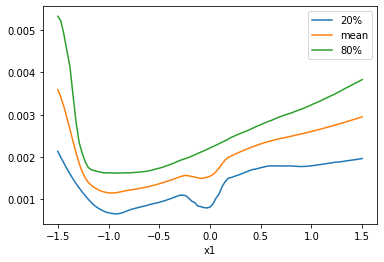

In [14]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

Epistemic uncertainty is high below -1 (where training data starts and is relatively low), decreases between -1 and 0, picks back up between 0 and 0.5, and then decreases between 0.5 and 1.  After 1, it doesn't perform exactly as desired, but is ticking up in some places.